# Uber Lyft Cab Price Prediction

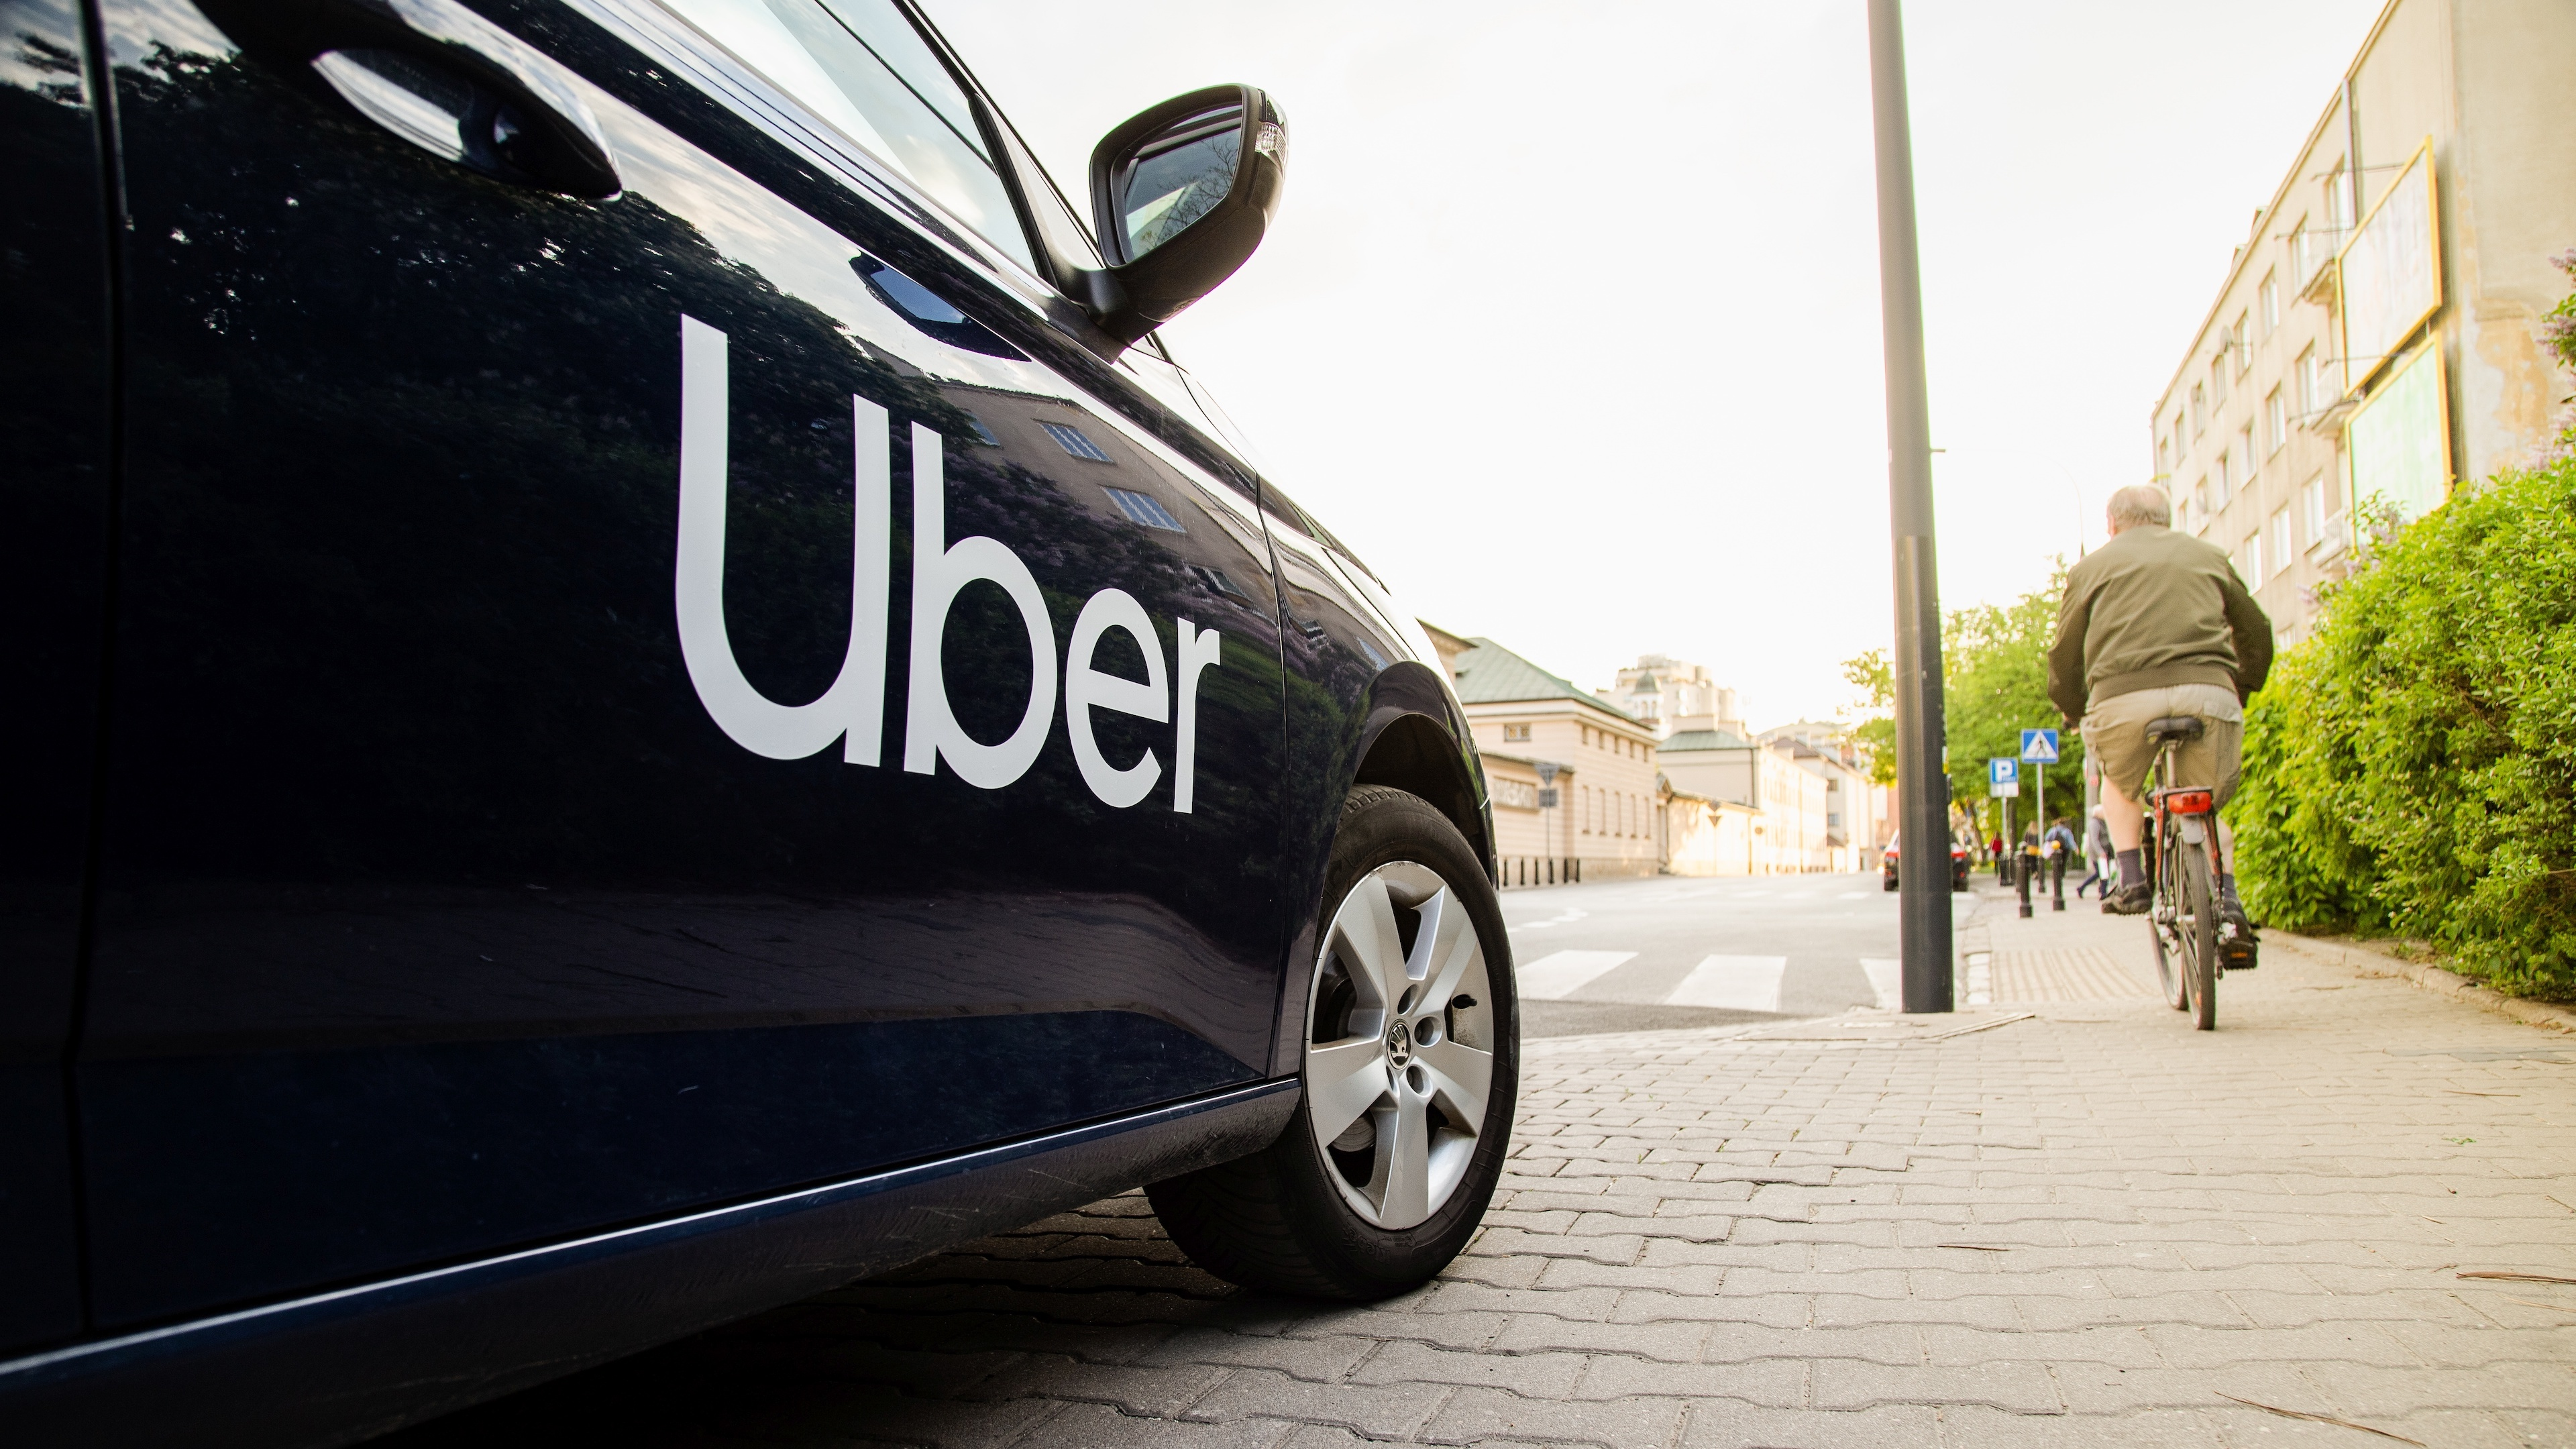

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import itertools
import gc
import os
import sys
%matplotlib inline
pd.set_option('display.max_columns', None )

In [95]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                #el
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [96]:
df1 = pd.read_csv('cab_rides.csv')
df1 = reduce_mem_usage(df1)
df2 = pd.read_csv('weather.csv')
df2 = reduce_mem_usage(df2)

Memory usage of dataframe is 52.88 MB --> 44.95 MB (Decreased by 15.0%)
Memory usage of dataframe is 0.38 MB --> 0.22 MB (Decreased by 43.7%)


## Data Understaning & Data cleaning

In [97]:
df1.head()

distance cab_type     time_stamp    destination            source  price  \
0      0.44     Lyft  1544952607890  North Station  Haymarket Square    5.0   
1      0.44     Lyft  1543284023677  North Station  Haymarket Square   11.0   
2      0.44     Lyft  1543366822198  North Station  Haymarket Square    7.0   
3      0.44     Lyft  1543553582749  North Station  Haymarket Square   26.0   
4      0.44     Lyft  1543463360223  North Station  Haymarket Square    9.0   

   surge_multiplier                                    id    product_id  \
0               1.0  424553bb-7174-41ea-aeb4-fe06d4f4b9d7     lyft_line   
1               1.0  4bd23055-6827-41c6-b23b-3c491f24e74d  lyft_premier   
2               1.0  981a3613-77af-4620-a42a-0c0866077d1e          lyft   
3               1.0  c2d88af2-d278-4bfd-a8d0-29ca77cc5512   lyft_luxsuv   
4               1.0  e0126e1f-8ca9-4f2e-82b3-50505a09db9a     lyft_plus   

           name  
0        Shared  
1           Lux  
2          Lyft  
3  Lux Black XL  
4       Lyft XL

In [98]:
df2.head()

temp            location  clouds     pressure    rain  time_stamp  \
0  42.419998            Back Bay     1.0  1012.140015  0.1228  1545003901   
1  42.430000         Beacon Hill     1.0  1012.150024  0.1846  1545003901   
2  42.500000   Boston University     1.0  1012.150024  0.1089  1545003901   
3  42.110001              Fenway     1.0  1012.130005  0.0969  1545003901   
4  43.130001  Financial District     1.0  1012.140015  0.1786  1545003901   

   humidity   wind  
0      0.77  11.25  
1      0.76  11.32  
2      0.76  11.07  
3      0.77  11.09  
4      0.75  11.49

In [99]:
df1.nunique()

distance               549
cab_type                 2
time_stamp          114335
destination             12
source                  12
price                  147
surge_multiplier         7
id                  693071
product_id              13
name                    13
dtype: int64

In [100]:
print(df1.isna().sum())
print('--'*15)
print('df2')
print(df2.isna().sum())

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64
------------------------------
df2
temp             0
location         0
clouds           0
pressure         0
rain          5382
time_stamp       0
humidity         0
wind             0
dtype: int64


- here in price feature 55095 values are missing so we drop this rows
- in df2['rain'] 5382 values are missing so we fill this null value as 0

In [101]:
df1.dropna(axis =0, inplace=True)
df1.reset_index(drop=True, inplace=True)

- now we dont have any null value under df1 dataframe

In [102]:
df2.fillna(0, inplace = True)

- now we dont have any null value under df2 dataframe

In [103]:
df2.groupby('location').mean()

temp    clouds     pressure      rain  \
location                                                              
Back Bay                 39.082119  0.678432  1008.447754  0.007925   
Beacon Hill              39.047287  0.677801  1008.448364  0.008297   
Boston University        39.047745  0.679235  1008.459229  0.007738   
Fenway                   38.964378  0.679866  1008.453247  0.007343   
Financial District       39.410820  0.676730  1008.435852  0.008563   
Haymarket Square         39.067898  0.676711  1008.445251  0.008660   
North End                39.090839  0.676730  1008.441895  0.008644   
North Station            39.035316  0.676998  1008.442749  0.008649   
Northeastern University  38.975086  0.678317  1008.444214  0.007358   
South Station            39.394089  0.677495  1008.437988  0.008310   
Theatre District         38.986713  0.677763  1008.444763  0.008405   
West End                 38.983402  0.677247  1008.441101  0.008657   

                           time_stamp  humidity      wind  
location                                                   
Back Bay                 1.543857e+09  0.764073  6.778528  
Beacon Hill              1.543857e+09  0.765048  6.810325  
Boston University        1.543857e+09  0.763786  6.692180  
Fenway                   1.543857e+09  0.767266  6.711721  
Financial District       1.543857e+09  0.754837  6.860019  
Haymarket Square         1.543857e+09  0.764838  6.843193  
North End                1.543857e+09  0.764054  6.853117  
North Station            1.543857e+09  0.765545  6.835755  
Northeastern University  1.543857e+09  0.767648  6.749426  
South Station            1.543857e+09  0.755468  6.848948  
Theatre District         1.543857e+09  0.767992  6.834302  
West End                 1.543857e+09  0.767266  6.816233

In [104]:
avg_weather_df = df2.groupby('location').mean().reset_index(drop=False)
avg_weather_df = avg_weather_df.drop('time_stamp', axis=1)
avg_weather_df

location       temp    clouds     pressure      rain  \
0                  Back Bay  39.082119  0.678432  1008.447754  0.007925   
1               Beacon Hill  39.047287  0.677801  1008.448364  0.008297   
2         Boston University  39.047745  0.679235  1008.459229  0.007738   
3                    Fenway  38.964378  0.679866  1008.453247  0.007343   
4        Financial District  39.410820  0.676730  1008.435852  0.008563   
5          Haymarket Square  39.067898  0.676711  1008.445251  0.008660   
6                 North End  39.090839  0.676730  1008.441895  0.008644   
7             North Station  39.035316  0.676998  1008.442749  0.008649   
8   Northeastern University  38.975086  0.678317  1008.444214  0.007358   
9             South Station  39.394089  0.677495  1008.437988  0.008310   
10         Theatre District  38.986713  0.677763  1008.444763  0.008405   
11                 West End  38.983402  0.677247  1008.441101  0.008657   

    humidity      wind  
0   0.764073  6.778528  
1   0.765048  6.810325  
2   0.763786  6.692180  
3   0.767266  6.711721  
4   0.754837  6.860019  
5   0.764838  6.843193  
6   0.764054  6.853117  
7   0.765545  6.835755  
8   0.767648  6.749426  
9   0.755468  6.848948  
10  0.767992  6.834302  
11  0.767266  6.816233

# Merging DataFrames

In [105]:
source_weather_df = avg_weather_df.rename(
    columns={
        'location': 'source',
        'temp': 'source_temp',
        'clouds': 'source_clouds',
        'pressure': 'source_pressure',
        'rain': 'source_rain',
        'humidity': 'source_humidity',
        'wind': 'source_wind'
    }
)

source_weather_df

source  source_temp  source_clouds  source_pressure  \
0                  Back Bay    39.082119       0.678432      1008.447754   
1               Beacon Hill    39.047287       0.677801      1008.448364   
2         Boston University    39.047745       0.679235      1008.459229   
3                    Fenway    38.964378       0.679866      1008.453247   
4        Financial District    39.410820       0.676730      1008.435852   
5          Haymarket Square    39.067898       0.676711      1008.445251   
6                 North End    39.090839       0.676730      1008.441895   
7             North Station    39.035316       0.676998      1008.442749   
8   Northeastern University    38.975086       0.678317      1008.444214   
9             South Station    39.394089       0.677495      1008.437988   
10         Theatre District    38.986713       0.677763      1008.444763   
11                 West End    38.983402       0.677247      1008.441101   

    source_rain  source_humidity  source_wind  
0      0.007925         0.764073     6.778528  
1      0.008297         0.765048     6.810325  
2      0.007738         0.763786     6.692180  
3      0.007343         0.767266     6.711721  
4      0.008563         0.754837     6.860019  
5      0.008660         0.764838     6.843193  
6      0.008644         0.764054     6.853117  
7      0.008649         0.765545     6.835755  
8      0.007358         0.767648     6.749426  
9      0.008310         0.755468     6.848948  
10     0.008405         0.767992     6.834302  
11     0.008657         0.767266     6.816233

In [106]:
# Merging both ride and weather data frame  
destination_weather_df = avg_weather_df.rename(
    columns={
        'location': 'destination',
        'temp': 'destination_temp',
        'clouds': 'destination_clouds',
        'pressure': 'destination_pressure',
        'rain': 'destination_rain',
        'humidity': 'destination_humidity',
        'wind': 'destination_wind'
    }
)

destination_weather_df

destination  destination_temp  destination_clouds  \
0                  Back Bay         39.082119            0.678432   
1               Beacon Hill         39.047287            0.677801   
2         Boston University         39.047745            0.679235   
3                    Fenway         38.964378            0.679866   
4        Financial District         39.410820            0.676730   
5          Haymarket Square         39.067898            0.676711   
6                 North End         39.090839            0.676730   
7             North Station         39.035316            0.676998   
8   Northeastern University         38.975086            0.678317   
9             South Station         39.394089            0.677495   
10         Theatre District         38.986713            0.677763   
11                 West End         38.983402            0.677247   

    destination_pressure  destination_rain  destination_humidity  \
0            1008.447754          0.007925              0.764073   
1            1008.448364          0.008297              0.765048   
2            1008.459229          0.007738              0.763786   
3            1008.453247          0.007343              0.767266   
4            1008.435852          0.008563              0.754837   
5            1008.445251          0.008660              0.764838   
6            1008.441895          0.008644              0.764054   
7            1008.442749          0.008649              0.765545   
8            1008.444214          0.007358              0.767648   
9            1008.437988          0.008310              0.755468   
10           1008.444763          0.008405              0.767992   
11           1008.441101          0.008657              0.767266   

    destination_wind  
0           6.778528  
1           6.810325  
2           6.692180  
3           6.711721  
4           6.860019  
5           6.843193  
6           6.853117  
7           6.835755  
8           6.749426  
9           6.848948  
10          6.834302  
11          6.816233

In [107]:
data = df1\
    .merge(source_weather_df, on='source')\
    .merge(destination_weather_df, on='destination')

- here id column is not usefull so drop this

In [108]:
data.drop('id', axis=1, inplace=True)

# EDA

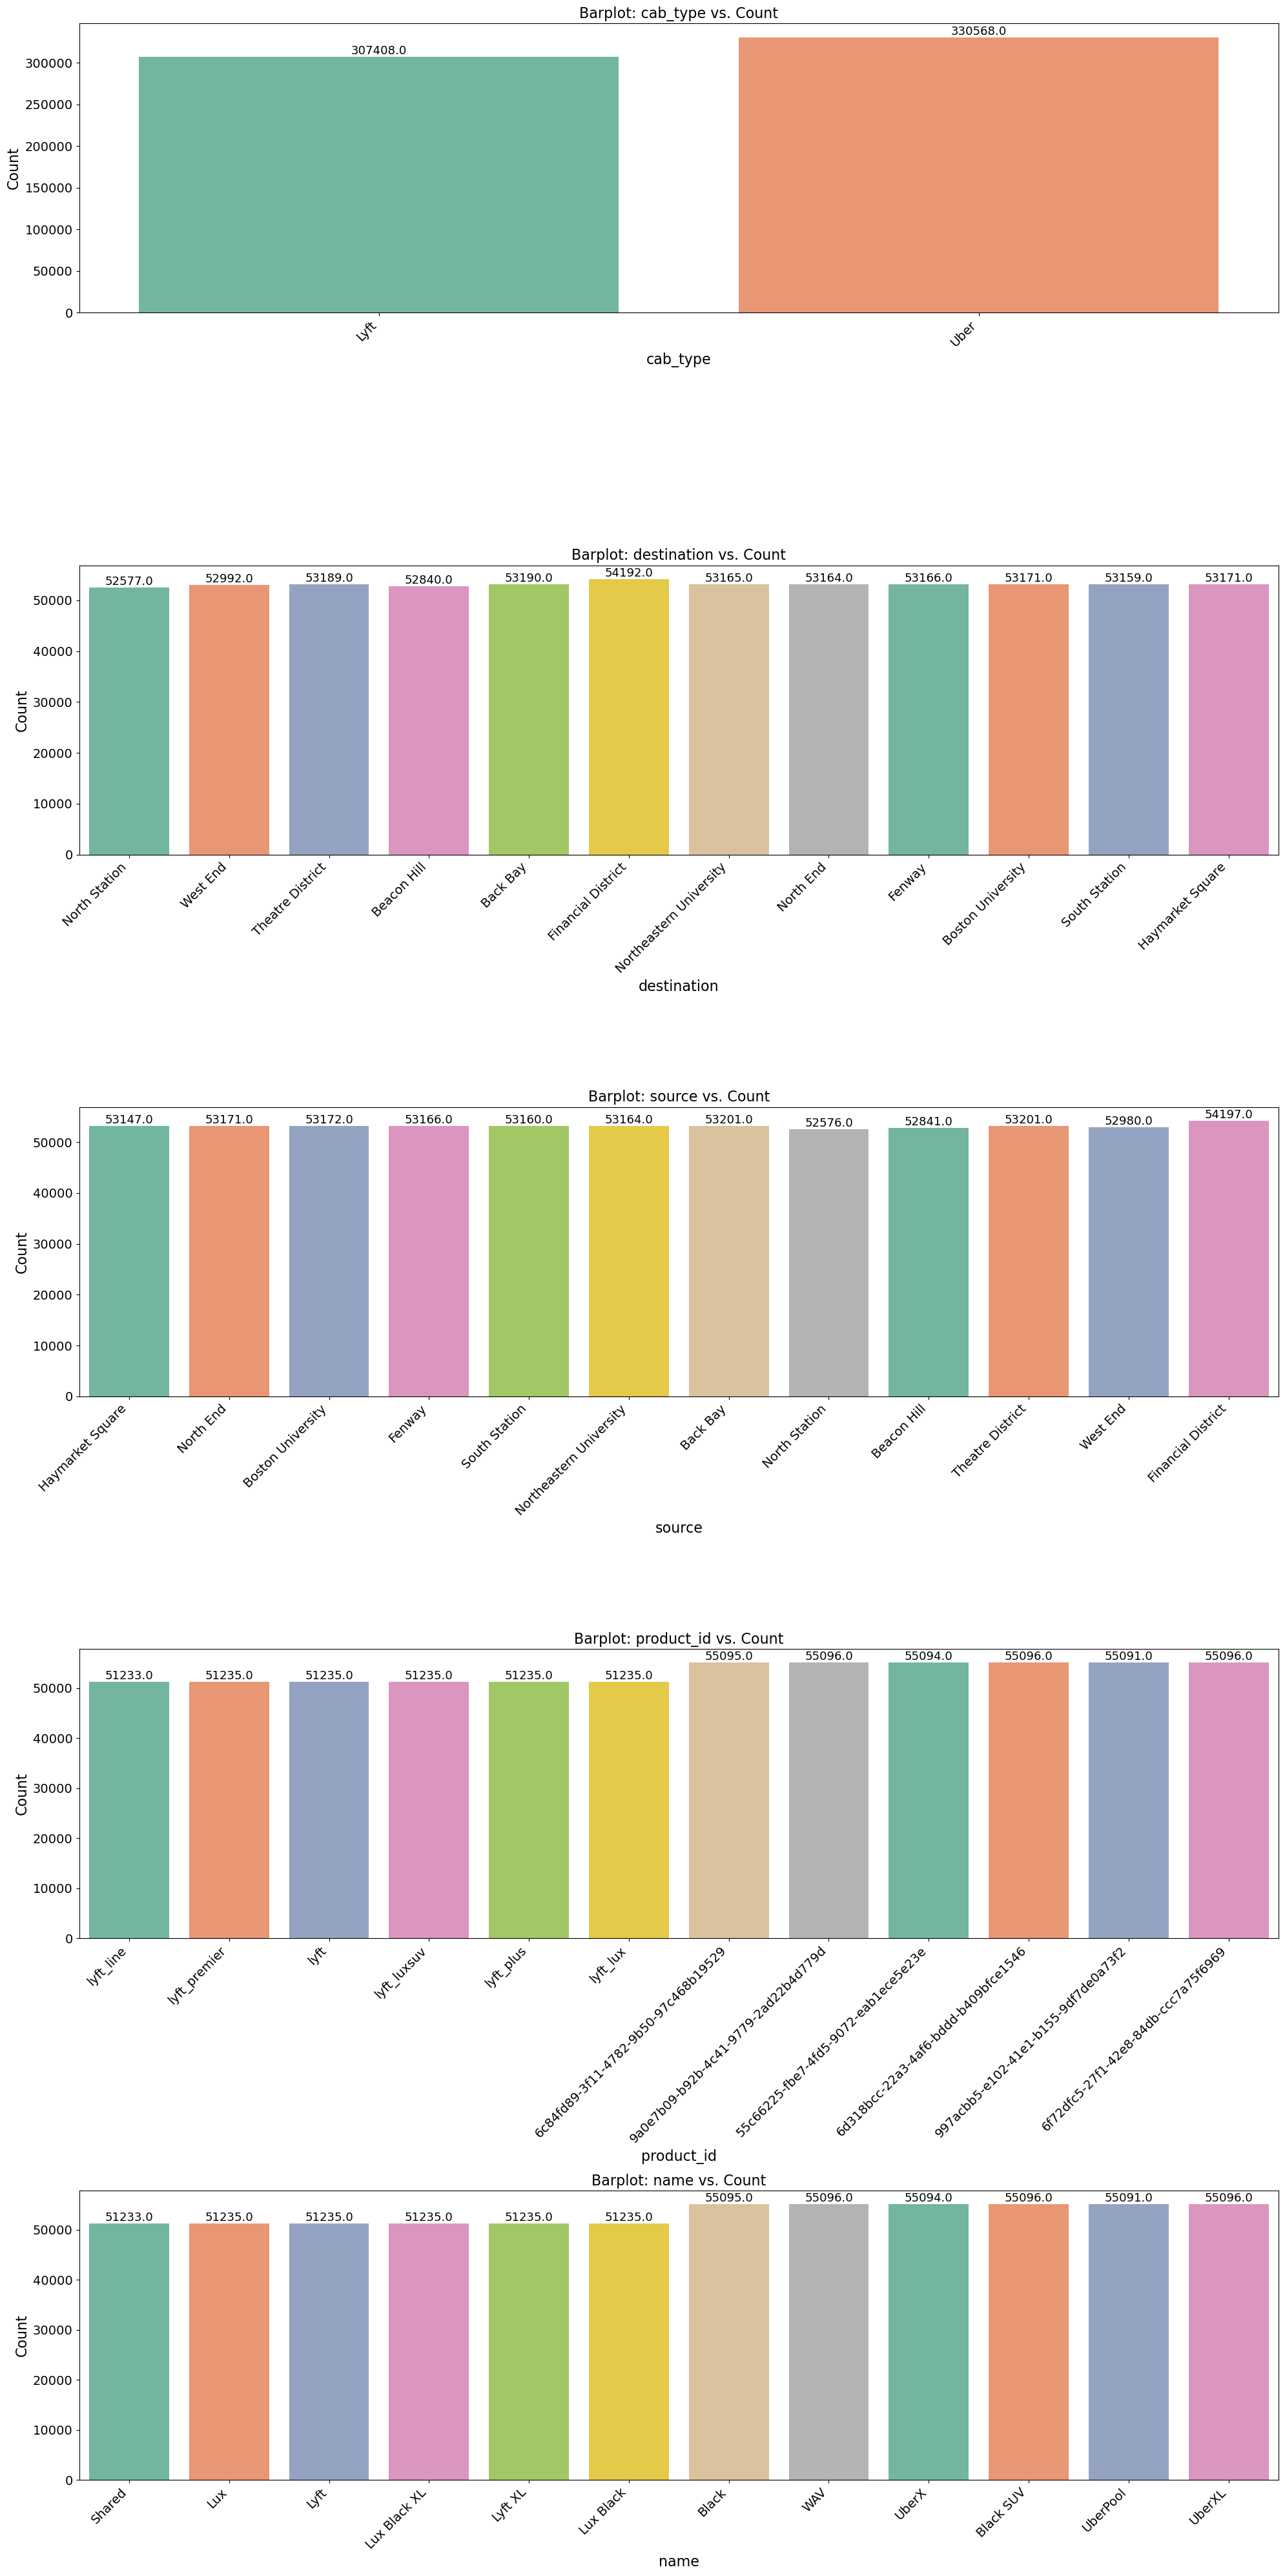

In [16]:
# Get the list of discrete variable columns
discrete_columns = data.select_dtypes(include='object').columns

# Calculate the number of rows for the subplot grid
n_rows = len(discrete_columns)

# Set the figure size
plt.figure(figsize=(20, 8 * n_rows))
colors = sns.color_palette("Set2")

# Loop through each discrete column and create a bar plot
for i, col in enumerate(discrete_columns):
    plt.subplot(n_rows, 1, i + 1)
    ax = sns.countplot(x=col, data=data, palette=colors)
    plt.xlabel(col, fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.title(f'Barplot: {col} vs. Count', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    
    # Print values on the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=13)

    plt.tight_layout()


plt.show()


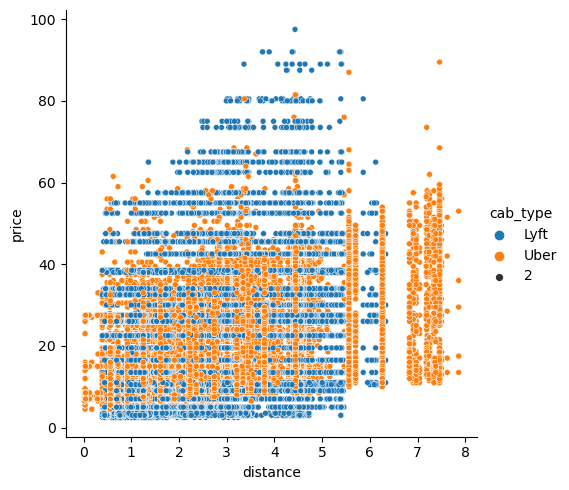

In [18]:
sns.relplot(x=data['distance'], y=data['price'], hue=data['cab_type'], size=2)
plt.show()

##### insights:
- as per above plot we clearly observe that for long distance uber cab is prefferred
- also the primary observation about the Lyft is the price is higher than uber as compare to distance

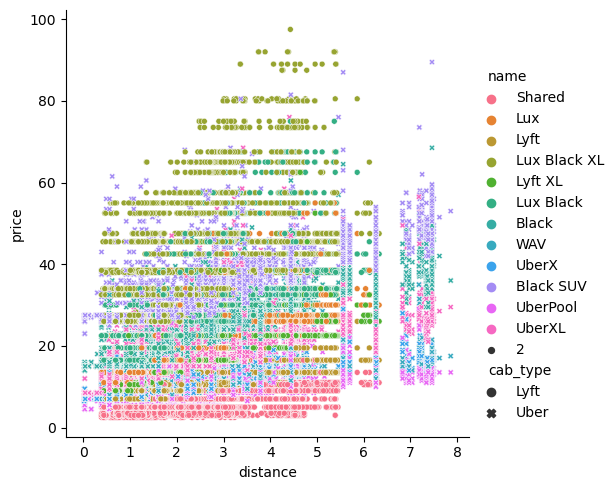

In [19]:
sns.relplot(x=data['distance'], y=data['price'], hue=data['name'], style= data['cab_type'],  size=2,)
plt.show()

##### insights
- primary observations
- price of Lux Black XL is very high 
- price of UberXL is low

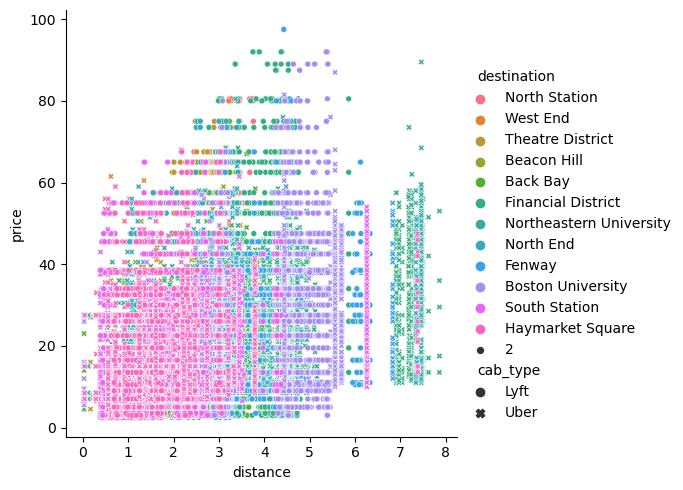

In [22]:
sns.relplot(x=data['distance'],y=data['price'],hue=data['destination'],style= data['cab_type'],size=2,)
plt.show()

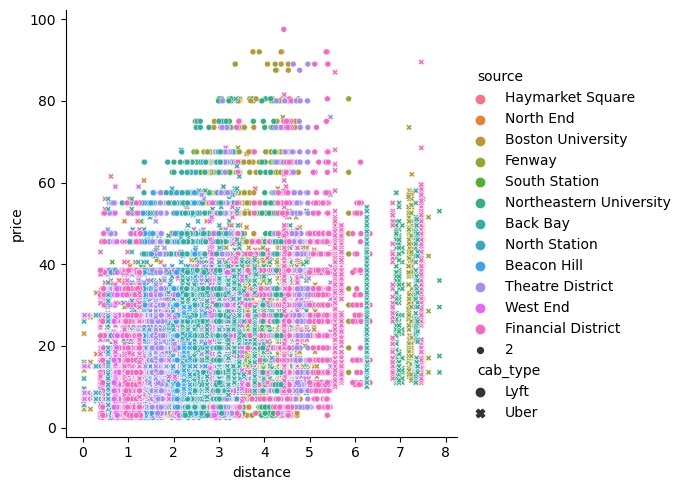

In [23]:
sns.relplot(x=data['distance'], y=data['price'], hue=data['source'],style= data['cab_type'], size=2,)
plt.show()

In [43]:
data.to_csv('cleaned_data.csv', index=False)

## Modeling

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [62]:
# writing function for creating dummy variables with the help of one hot encoding 
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [66]:
from sklearn.preprocessing import StandardScaler

def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

def preprocess_inputs(df):
    df = df.copy()
    
    # Binary encode cab_type column
    df['cab_type'] = df['cab_type'].replace({'Lyft': 0, 'Uber': 1})
    
    # One-hot encode remaining categorical columns
    for column, prefix in [('destination', "dest"), ('source', "src"), ('product_id', "pid"), ('name', "nm")]:
        df = onehot_encode(df, column=column, prefix=prefix)
    
    # Split df into X and y
    y = df['price']
    X = df.drop('price', axis=1)
    
    # Train-test split (You can choose to keep this step if needed for later use)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)
    
    # Scale X (You can choose to keep this step if needed for later use)
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns)
    
    # Merge features and target into the preprocessed DataFrame
    df_preprocessed = pd.concat([X_train, X_test], ignore_index=True)
    df_preprocessed['price'] = pd.concat([y_train, y_test], ignore_index=True)
    
    return df_preprocessed


In [72]:
df_preprocessed = preprocess_inputs(data)


In [68]:
y = df_preprocessed['price']
X = df_preprocessed.drop('price', axis=1)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

In [70]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((446583, 64), (191393, 64), (446583,), (191393,))

### Creating an Evaluate Function to give all metrics after model Training

In [71]:
#modelling with Linear regression
from sklearn.linear_model import LinearRegression 
model = LinearRegression()
model.fit(X_train, y_train)

train_prediction = model.predict(X_train)
test_prediction = model.predict(X_test)

from sklearn.model_selection import cross_val_score

print('Test R2 :', model.score(X_test, y_test))
print('Train R2 :',model.score(X_train, y_train))
print('cross validation score :', cross_val_score(model,X,y,cv=5).mean())

Test R2 : 0.9285273837007065
Train R2 : 0.9285909639857179
cross validation score : 0.9285954418498443


## check 

In [80]:
test_res = y_test - test_prediction

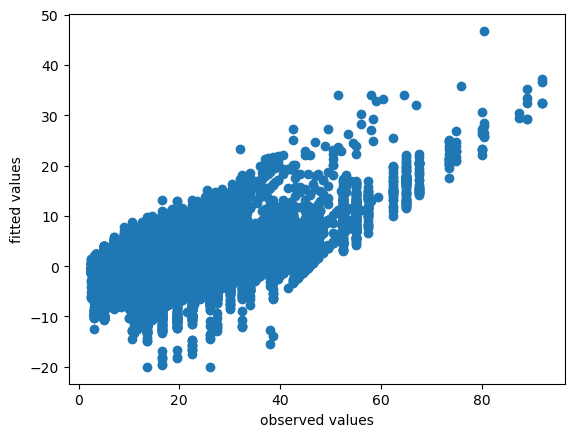

In [81]:
# linearity of error
plt.scatter(y_test, test_res)
plt.xlabel('observed values')
plt.ylabel('fitted values')
plt.show()

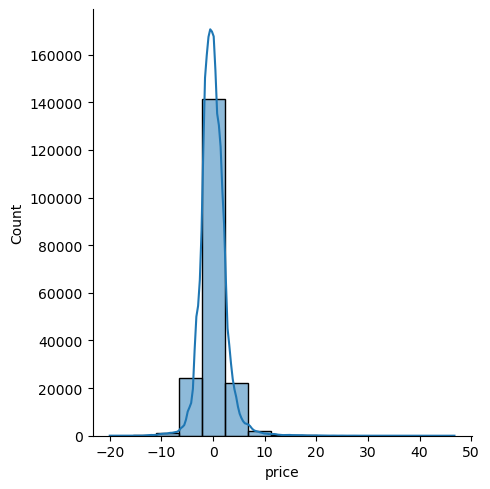

In [82]:
# normality of errors
sns.displot(test_res, bins=15, kde=True)
plt.show()

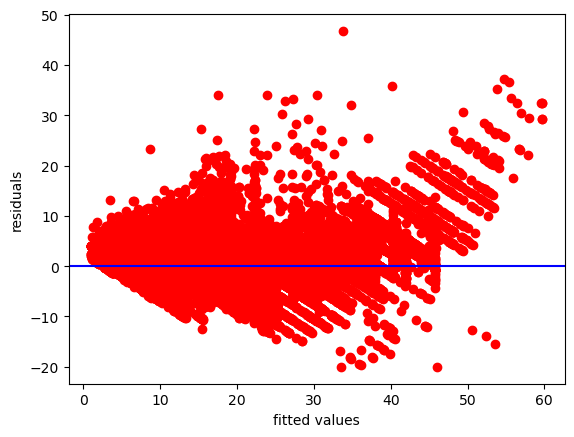

In [83]:
# Equal Variance of Error (homoscadesicity)
plt.scatter(test_prediction, test_res, c="r")
plt.axhline(y=0, color='blue')
plt.xlabel('fitted values')
plt.ylabel('residuals')
plt.show()

In [85]:
# Variable significance
import statsmodels.formula.api as smf 
model1 = smf.ols('y~X', data=df_preprocessed).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.363e+05
Date:                Mon, 24 Jul 2023   Prob (F-statistic):               0.00
Time:                        00:40:00   Log-Likelihood:            -1.4886e+06
No. Observations:              637976   AIC:                         2.977e+06
Df Residuals:                  637940   BIC:                         2.978e+06
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.4385      1.723     10.121      0.000      14.062      20.815
X[0]           3.2762      0.005    695.957      0.000       3.267       3.285
X[1]       -3.033e+11   3.88e+11     -0.782      0.434   -1.06e+12    4.57e+11
X[2]           0.0012      0.003      0.379      0.705      -0.005       0.007
X[3]           1.7582      0.003    545.203      0.000       1.752       1.765
X[4]         1.57e+11   2.25e+11      0.697      0.486   -2.85e+11    5.98e+11
X[5]        2.944e+10   2.98e+11      0.099      0.921   -5.54e+11    6.13e+11
X[6]       -1.179e+11   5.44e+11     -0.217      0.829   -1.18e+12    9.49e+11
X[7]       -1.386e+10   2.25e+11     -0.062      0.951   -4.55e+11    4.28e+11
X[8]        7.143e+10   4.97e+11      0.144      0.886   -9.03e+11    1.05e+12
X[9]       -6.478e+11    4.2e+11     -1.541      0.123   -1.47e+12    1.76e+11
X[10]      -9.161e+11   5.29e+11     -1.732      0.083   -1.95e+12    1.21e+11
X[11]       8.769e+11   4.52e+11      1.940      0.052   -8.97e+09    1.76e+12
X[12]      -3.605e+11   5.12e+11     -0.705      0.481   -1.36e+12    6.42e+11
X[13]      -5.884e+11   5.16e+11     -1.141      0.254    -1.6e+12    4.22e+11
X[14]      -4.745e+11   3.28e+11     -1.447      0.148   -1.12e+12    1.68e+11
X[15]       8.559e+11   5.33e+11      1.605      0.109   -1.89e+11     1.9e+12
X[16]      -2.291e+11   2.29e+11     -0.998      0.318   -6.79e+11    2.21e+11
X[17]      -1.042e+11   2.35e+11     -0.443      0.658   -5.65e+11    3.57e+11
X[18]       2.932e+11   2.17e+11      1.350      0.177   -1.33e+11    7.19e+11
X[19]       -2.15e+11   1.22e+11     -1.766      0.077   -4.54e+11    2.36e+10
X[20]       1.478e+11   1.55e+11      0.956      0.339   -1.55e+11    4.51e+11
X[21]       4.195e+11   2.51e+11      1.668      0.095   -7.34e+10    9.12e+11
X[22]       3.275e+11   2.19e+11      1.498      0.134   -1.01e+11    7.56e+11
X[23]        7.76e+09   2.33e+11      0.033      0.973   -4.49e+11    4.64e+11
X[24]      -1.057e+11   2.02e+11     -0.525      0.600   -5.01e+11    2.89e+11
X[25]       2.387e+11   3.55e+11      0.673      0.501   -4.57e+11    9.34e+11
X[26]      -2.342e+11    2.6e+11     -0.900      0.368   -7.44e+11    2.76e+11
X[27]      -2.961e+10   2.94e+11     -0.101      0.920   -6.07e+11    5.48e+11
X[28]      -1.191e+11   2.72e+11     -0.438      0.661   -6.52e+11    4.14e+11
X[29]       2.394e+09   2.33e+11      0.010      0.992   -4.55e+11    4.59e+11
X[30]      -4.319e+10   5.04e+11     -0.086      0.932   -1.03e+12    9.45e+11
X[31]      -1.086e+10   3.42e+11     -0.032      0.975   -6.81e+11    6.59e+11
X[32]       4.984e+10   3.29e+11      0.151      0.880   -5.96e+11    6.95e+11
X[33]       3.942e+11      2e+11      1.975      0.048    3.08e+09    7.85e+11
X[34]       4.052e+11   2.15e+11      1.888      0.059   -1.54e+10    8.26e+11
X[

In [90]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':test_prediction,
                      'Difference':y_test-test_prediction})
pred_df

Actual Value  Predicted Value  Difference
606015           6.5         5.226984    1.273016
503810          11.0        11.386080   -0.386080
207240           5.0         5.015963   -0.015963
331602          27.0        26.660983    0.339017
584694          15.0        17.152682   -2.152682
...              ...              ...         ...
443768           7.5         5.305109    2.194891
401784          10.5        11.371798   -0.871798
519043           7.5         6.807062    0.692938
438652           5.5         4.306002    1.193998
328750          16.5        17.105563   -0.605563

[191393 rows x 3 columns]

## By Using Linear Regression I achived 92% accuracy 
### Test R2 : 0.9285273837007065
### Train R2 : 0.9285909639857179
### cross validation score : 0.9285954418498443

author : Shubham Khairmode

feedback : shubhambkhairmode@gmail.com